# **Fake News Detection on Reddit Post Titles**

# **Install Required Libraries**

In [1]:
!pip install xgboost
!pip install streamlit
!pip install joblib
!pip install nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.3 MB/s eta 0:00:00


# **Import Libraries and Download NLTK Data**

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Load Data**

In [12]:
train_df = pd.read_csv('xy_train.csv')
test_df = pd.read_csv('x_test.csv')

print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print(train_df.head())
print(train_df['label'].value_counts())


Train Data Shape: (48000, 3)
Test Data Shape: (11955, 2)
   ID                                               text  label
0   0  Americans Aren't Sure If Flight 370 Vanished T...      1
1   1  Pope Leo X offering indulgences to sinners sho...      0
2   2  News: 5 Uplifting Hypotheticals Of What Could ...      0
3   3  George W. Bush and Jeb Bush at a campaign stop...      0
4   4  The WADA requesting their fair share from Lanc...      0
label
0    25798
1    22015
2      187
Name: count, dtype: int64


# **Data Understanding & Exploration**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      48000 non-null  int64 
 1   text    48000 non-null  object
 2   label   48000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB
None

Label Distribution:
label
0    25798
1    22015
2      187
Name: count, dtype: int64


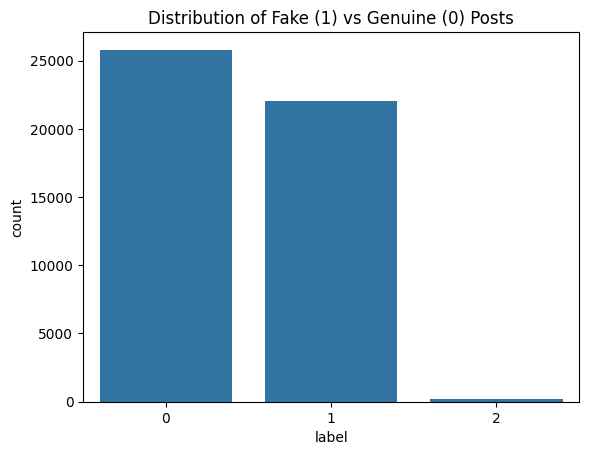

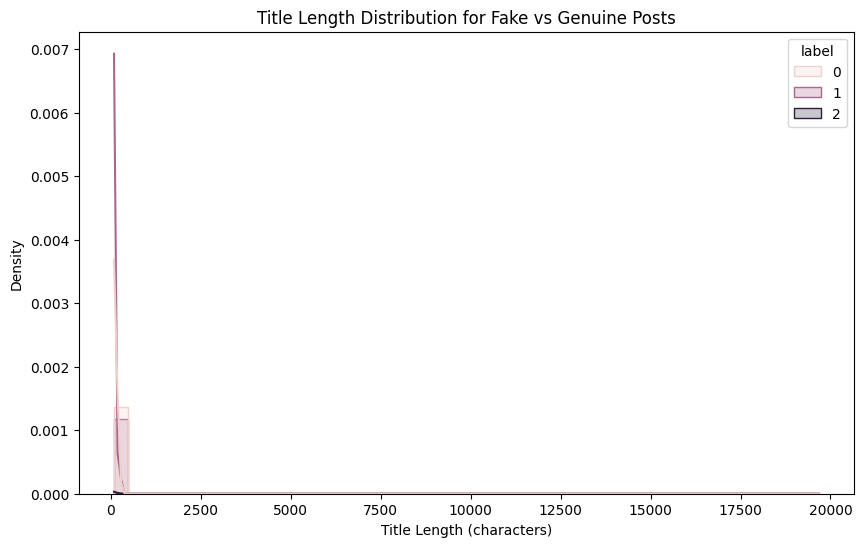

Top 20 Common Words in Fake Posts:
[('new', 1116), ('like', 1098), ('one', 1048), ('found', 1015), ('man', 943), ('psbattle:', 867), ('years', 795), ('old', 693), ('people', 668), ('first', 639), ('says', 590), ('two', 580), ('school', 574), ('police', 555), ('trump', 539), ('made', 515), ('looks', 509), ('year', 489), ('woman', 484), ('back', 482)]

Top 20 Common Words in Genuine Posts:
[('one', 1218), ('new', 1170), ('like', 1121), ('first', 1082), ('colorized)', 1018), ('trump', 989), ('poster', 978), ('man', 843), ('people', 812), ('war', 795), ('true', 782), ('get', 690), ('american', 674), ('german', 568), ('president', 564), ('would', 561), ('time', 551), ('photo', 538), ('make', 535), ('know', 522)]


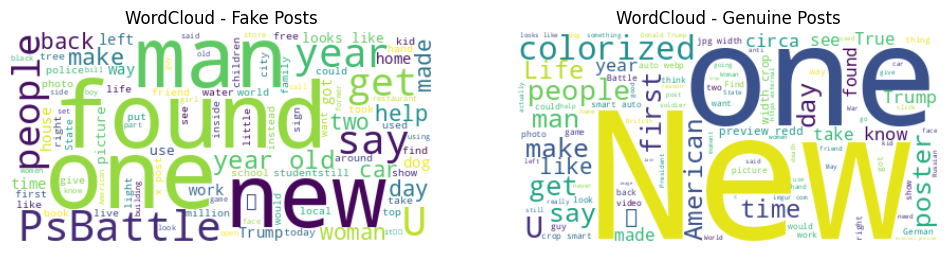


Note: No engagement features like upvotes or comments present in the dataset.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from collections import Counter

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Assuming train_df is loaded with columns: ID, text, label

# 1. Basic info and label distribution
print("Dataset Info:")
print(train_df.info())

print("\nLabel Distribution:")
print(train_df['label'].value_counts())

sns.countplot(x='label', data=train_df)
plt.title('Distribution of Fake (1) vs Genuine (0) Posts')
plt.show()

# 2. Title length analysis
train_df['title_length'] = train_df['text'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(data=train_df, x='title_length', hue='label', bins=50, kde=True, element='step', stat='density')
plt.title('Title Length Distribution for Fake vs Genuine Posts')
plt.xlabel('Title Length (characters)')
plt.ylabel('Density')
plt.show()

# 3. Extract common words
def get_common_words(texts, num=20):
    words = []
    for text in texts:
        for word in text.lower().split():
            if word not in stop_words and len(word) > 2:
                words.append(word)
    return Counter(words).most_common(num)

fake_words = get_common_words(train_df[train_df['label'] == 1]['text'])
print("Top 20 Common Words in Fake Posts:")
print(fake_words)

genuine_words = get_common_words(train_df[train_df['label'] == 0]['text'])
print("\nTop 20 Common Words in Genuine Posts:")
print(genuine_words)

# 4. WordCloud visualization
fake_text = ' '.join(train_df[train_df['label'] == 1]['text'].tolist())
genuine_text = ' '.join(train_df[train_df['label'] == 0]['text'].tolist())

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
wc_fake = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(fake_text)
plt.imshow(wc_fake, interpolation='bilinear')
plt.title('WordCloud - Fake Posts')
plt.axis('off')

plt.subplot(1,2,2)
wc_genuine = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(genuine_text)
plt.imshow(wc_genuine, interpolation='bilinear')
plt.title('WordCloud - Genuine Posts')
plt.axis('off')

plt.show()

# 5. Engagement columns check (likely none)
print("\nNote: No engagement features like upvotes or comments present in the dataset.")


**Check what those rows with label 2 contain (to understand what they are):**

In [9]:
print(train_df[train_df['label'] == 2].head())


        ID                                               text  label  \
314    314  First Gay Miss America Contestant: 鈥淚鈥檓 Sure E...      2   
790    790  The Platinum Games character 鈥淵oRHa No.2 Type ...      2   
959    959  News: Silencing Dissent: Donald Trump Just Thr...      2   
1350  1350  Russian soldier using his surroundings to make...      2   
1402  1402  Kanye's philosophy book could explain why he d...      2   

                                             clean_text  title_length  
314   first gay miss america contestant sure everyon...            87  
790   platinum game character orha type bfrom game i...            88  
959   news silencing dissent donald trump threw elde...           130  
1350  russian soldier using surroundings make primit...            94  
1402  kanyes philosophy book could explain deleted t...           294  


**Remove rows with label 2**

In [15]:
train_df = train_df[train_df['label'].isin([0, 1])]

**Data Understanding & Exploration after removing the label 2**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 47813 entries, 0 to 47999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            47813 non-null  int64 
 1   text          47813 non-null  object
 2   label         47813 non-null  int64 
 3   title_length  47813 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.8+ MB
None

Label Distribution:
label
0    25798
1    22015
Name: count, dtype: int64


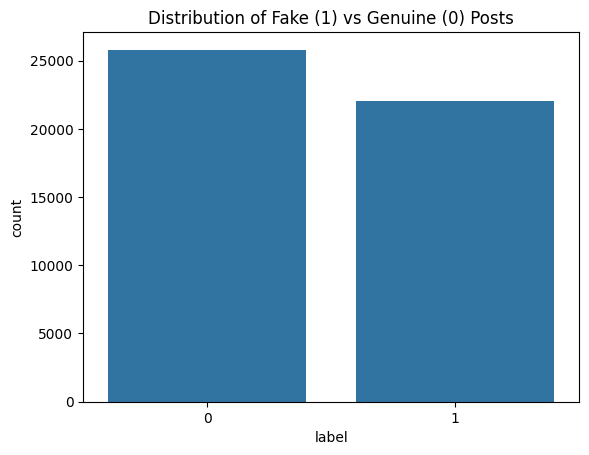

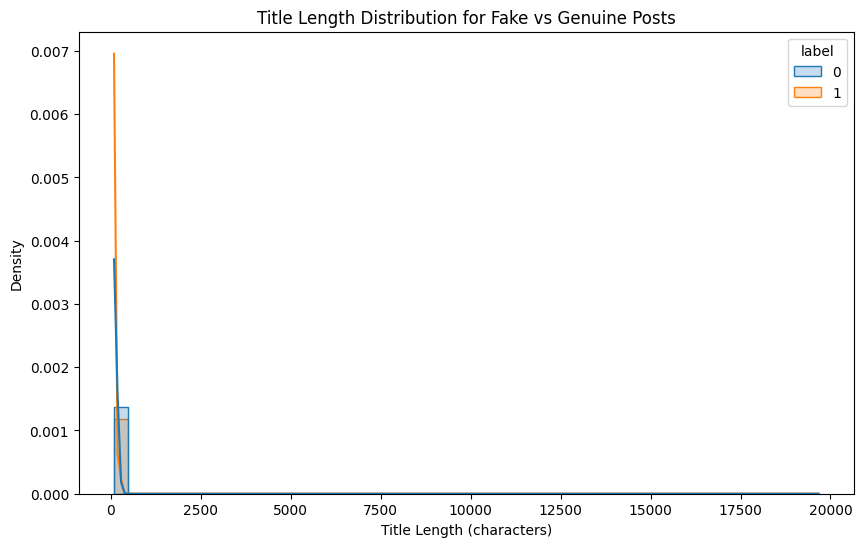

Top 20 Common Words in Fake Posts:
[('new', 1116), ('like', 1098), ('one', 1048), ('found', 1015), ('man', 943), ('psbattle:', 867), ('years', 795), ('old', 693), ('people', 668), ('first', 639), ('says', 590), ('two', 580), ('school', 574), ('police', 555), ('trump', 539), ('made', 515), ('looks', 509), ('year', 489), ('woman', 484), ('back', 482)]

Top 20 Common Words in Genuine Posts:
[('one', 1218), ('new', 1170), ('like', 1121), ('first', 1082), ('colorized)', 1018), ('trump', 989), ('poster', 978), ('man', 843), ('people', 812), ('war', 795), ('true', 782), ('get', 690), ('american', 674), ('german', 568), ('president', 564), ('would', 561), ('time', 551), ('photo', 538), ('make', 535), ('know', 522)]


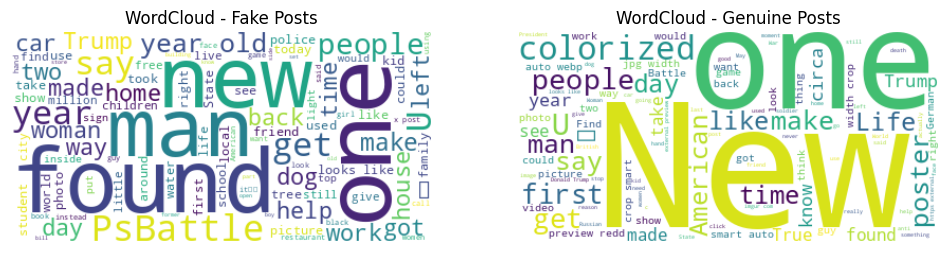


Note: No engagement features like upvotes or comments present in the dataset.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from collections import Counter

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Assuming train_df is loaded with columns: ID, text, label

# 1. Basic info and label distribution
print("Dataset Info:")
print(train_df.info())

print("\nLabel Distribution:")
print(train_df['label'].value_counts())

sns.countplot(x='label', data=train_df)
plt.title('Distribution of Fake (1) vs Genuine (0) Posts')
plt.show()

# 2. Title length analysis
train_df['title_length'] = train_df['text'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(data=train_df, x='title_length', hue='label', bins=50, kde=True, element='step', stat='density')
plt.title('Title Length Distribution for Fake vs Genuine Posts')
plt.xlabel('Title Length (characters)')
plt.ylabel('Density')
plt.show()

# 3. Extract common words
def get_common_words(texts, num=20):
    words = []
    for text in texts:
        for word in text.lower().split():
            if word not in stop_words and len(word) > 2:
                words.append(word)
    return Counter(words).most_common(num)

fake_words = get_common_words(train_df[train_df['label'] == 1]['text'])
print("Top 20 Common Words in Fake Posts:")
print(fake_words)

genuine_words = get_common_words(train_df[train_df['label'] == 0]['text'])
print("\nTop 20 Common Words in Genuine Posts:")
print(genuine_words)

# 4. WordCloud visualization
fake_text = ' '.join(train_df[train_df['label'] == 1]['text'].tolist())
genuine_text = ' '.join(train_df[train_df['label'] == 0]['text'].tolist())

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
wc_fake = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(fake_text)
plt.imshow(wc_fake, interpolation='bilinear')
plt.title('WordCloud - Fake Posts')
plt.axis('off')

plt.subplot(1,2,2)
wc_genuine = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(genuine_text)
plt.imshow(wc_genuine, interpolation='bilinear')
plt.title('WordCloud - Genuine Posts')
plt.axis('off')

plt.show()

# 5. Engagement columns check (likely none)
print("\nNote: No engagement features like upvotes or comments present in the dataset.")


# **Data Preprocessing**

In [38]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [40]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
tokenizer = TreebankWordTokenizer()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Common sarcasm indicators & vague words to handle
sarcasm_phrases = ['yeah right', 'as if', 'totally', 'sure', 'lol', 'haha', 'jk', 'whatever']
vague_words = ['something', 'stuff', 'thing', 'anything', 'whatever', 'whatever']

def detect_and_tag_sarcasm(text):
    # Lowercase text for matching
    text_lower = text.lower()
    for phrase in sarcasm_phrases:
        if phrase in text_lower:
            return '<sarcasm>'
    return ''

def replace_vague_words(tokens):
    return ['<vague>' if word in vague_words else word for word in tokens]

def preprocess_text(text, use_stemming=True):
    # Handle very short texts (e.g., less than 3 words)
    if len(text.split()) < 3:
        return '<short_text>'

    # Detect sarcasm phrases
    sarcasm_tag = detect_and_tag_sarcasm(text)

    # Lowercase
    text = text.lower()

    # Remove special characters and punctuation (keep letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize
    tokens = tokenizer.tokenize(text)

    # Replace vague words
    tokens = replace_vague_words(tokens)

    # Remove stopwords and apply stemming/lemmatization
    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    else:
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    processed_text = ' '.join(tokens)

    # Append sarcasm tag if detected
    if sarcasm_tag:
        processed_text = sarcasm_tag + ' ' + processed_text

    return processed_text

# Apply preprocessing to train and test
train_df['clean_text'] = train_df['text'].apply(lambda x: preprocess_text(x, use_stemming=True))
test_df['clean_text'] = test_df['text'].apply(lambda x: preprocess_text(x, use_stemming=True))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# **Feature Engineering**

In [41]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import re

# Assuming train_df and test_df are loaded with columns: ID, text, label (train_df), and text (test_df)
# Assuming you already did text preprocessing and have clean_text columns.

# --- Custom Feature Functions ---

def count_exclamations(text):
    return text.count('!')

def count_all_caps_words(text):
    # Count words fully uppercase, at least length 2 (avoid single-letter caps)
    words = text.split()
    return sum(1 for w in words if w.isupper() and len(w) > 1)

def title_length(text):
    return len(text)

# Add custom features to both train and test dataframes
for df in [train_df, test_df]:
    df['title_length'] = df['text'].apply(title_length)
    df['exclamation_count'] = df['text'].apply(count_exclamations)
    df['all_caps_count'] = df['text'].apply(count_all_caps_words)

# --- Vectorizers ---

# 1. TF-IDF Vectorizer (word n-grams: 1 to 2)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)

# Fit on train clean_text and transform both train and test
X_tfidf_train = tfidf_vectorizer.fit_transform(train_df['clean_text'])
X_tfidf_test = tfidf_vectorizer.transform(test_df['clean_text'])

# 2. CountVectorizer (word n-grams: 1 to 2)
count_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=5000)

X_count_train = count_vectorizer.fit_transform(train_df['clean_text'])
X_count_test = count_vectorizer.transform(test_df['clean_text'])

# 3. Character n-grams (3 to 5 chars)
char_vectorizer = CountVectorizer(analyzer='char', ngram_range=(3,5), max_features=3000)

X_char_train = char_vectorizer.fit_transform(train_df['clean_text'])
X_char_test = char_vectorizer.transform(test_df['clean_text'])

# --- Combine all features ---

from scipy.sparse import hstack

# Custom features need to be reshaped and converted to sparse matrix for hstack
custom_features_train = np.vstack([
    train_df['title_length'],
    train_df['exclamation_count'],
    train_df['all_caps_count']
]).T

custom_features_test = np.vstack([
    test_df['title_length'],
    test_df['exclamation_count'],
    test_df['all_caps_count']
]).T

from scipy.sparse import csr_matrix

custom_features_train_sparse = csr_matrix(custom_features_train)
custom_features_test_sparse = csr_matrix(custom_features_test)

# Combine sparse matrices horizontally
X_train_final = hstack([X_tfidf_train, X_count_train, X_char_train, custom_features_train_sparse])
X_test_final = hstack([X_tfidf_test, X_count_test, X_char_test, custom_features_test_sparse])

print("Shape of final training feature matrix:", X_train_final.shape)
print("Shape of final test feature matrix:", X_test_final.shape)


Shape of final training feature matrix: (47813, 13003)
Shape of final test feature matrix: (11955, 13003)


# **Model Building**

In [42]:
pip install scikit-learn xgboost tensorflow


In [47]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Assuming train_df is your DataFrame with 'clean_text' and 'label' columns

# Split data into train and validation sets (80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(
    train_df['clean_text'], train_df['label'], test_size=0.2, random_state=42, stratify=train_df['label'])

# Logistic Regression pipeline
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
    ('clf', LogisticRegression(max_iter=200, random_state=42))
])
lr_pipeline.fit(X_train, y_train)
lr_preds = lr_pipeline.predict(X_val)

print("Logistic Regression Results:")
print(classification_report(y_val, lr_preds))
print("Accuracy:", accuracy_score(y_val, lr_preds))

# Random Forest pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_val)

print("\nRandom Forest Results:")
print(classification_report(y_val, rf_preds))
print("Accuracy:", accuracy_score(y_val, rf_preds))

# XGBoost pipeline
xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_val)

print("\nXGBoost Results:")
print(classification_report(y_val, xgb_preds))
print("Accuracy:", accuracy_score(y_val, xgb_preds))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      5160
           1       0.77      0.77      0.77      4403

    accuracy                           0.79      9563
   macro avg       0.78      0.78      0.78      9563
weighted avg       0.79      0.79      0.79      9563

Accuracy: 0.785213845027711

Random Forest Results:
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      5160
           1       0.73      0.75      0.74      4403

    accuracy                           0.76      9563
   macro avg       0.76      0.76      0.76      9563
weighted avg       0.76      0.76      0.76      9563

Accuracy: 0.7596988392763777


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:23:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      5160
           1       0.74      0.70      0.72      4403

    accuracy                           0.75      9563
   macro avg       0.75      0.75      0.75      9563
weighted avg       0.75      0.75      0.75      9563

Accuracy: 0.7496601484889679


# **Hyperparameter Tuning**

In [48]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Optional: Use a smaller sample for faster tuning
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.3, stratify=y_train, random_state=42)

# Common vectorizer settings (simplified for speed)
tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=1000)

# -----------------------------
# 1. Logistic Regression
# -----------------------------
lr_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', LogisticRegression(max_iter=200, random_state=42))
])

lr_param_grid = {
    'clf__C': [0.1, 1],
    'clf__solver': ['liblinear']
}

lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
lr_grid.fit(X_sample, y_sample)

print("\n✅ Best Logistic Regression Params:", lr_grid.best_params_)
print("✅ Best Logistic Regression CV Score:", lr_grid.best_score_)

# -----------------------------
# 2. Random Forest
# -----------------------------
rf_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'clf__n_estimators': [100],
    'clf__max_depth': [None, 10]
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid.fit(X_sample, y_sample)

print("\n✅ Best Random Forest Params:", rf_grid.best_params_)
print("✅ Best Random Forest CV Score:", rf_grid.best_score_)

# -----------------------------
# 3. XGBoost
# -----------------------------
xgb_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_param_grid = {
    'clf__n_estimators': [100],
    'clf__max_depth': [3, 6],
    'clf__learning_rate': [0.1]
}

xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
xgb_grid.fit(X_sample, y_sample)

print("\n✅ Best XGBoost Params:", xgb_grid.best_params_)
print("✅ Best XGBoost CV Score:", xgb_grid.best_score_)


Fitting 3 folds for each of 2 candidates, totalling 6 fits

✅ Best Logistic Regression Params: {'clf__C': 1, 'clf__solver': 'liblinear'}
✅ Best Logistic Regression CV Score: 0.7222657952069717
Fitting 3 folds for each of 2 candidates, totalling 6 fits

✅ Best Random Forest Params: {'clf__max_depth': None, 'clf__n_estimators': 100}
✅ Best Random Forest CV Score: 0.712069716775599
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:25:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Best XGBoost Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 100}
✅ Best XGBoost CV Score: 0.6834858387799564


In [49]:
# Get the best estimators from GridSearchCV objects
best_lr_model = lr_grid.best_estimator_
best_rf_model = rf_grid.best_estimator_
best_xgb_model = xgb_grid.best_estimator_

# Print the best parameters and a confirmation message
print("Best Logistic Regression Model:")
print(lr_grid.best_params_)
print()

print("Best Random Forest Model:")
print(rf_grid.best_params_)
print()

print("Best XGBoost Model:")
print(xgb_grid.best_params_)
print()

print("Best models extracted from Grid Search are ready for evaluation.")


Best Logistic Regression Model:
{'clf__C': 1, 'clf__solver': 'liblinear'}

Best Random Forest Model:
{'clf__max_depth': None, 'clf__n_estimators': 100}

Best XGBoost Model:
{'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 100}

Best models extracted from Grid Search are ready for evaluation.


# **Evaluation**

--- Logistic Regression Evaluation ---
ROC-AUC Score: 0.8212
Accuracy: 0.7377
Precision: 0.7200
Recall: 0.7043
F1-Score: 0.7121
Confusion Matrix:
[[3954 1206]
 [1302 3101]]


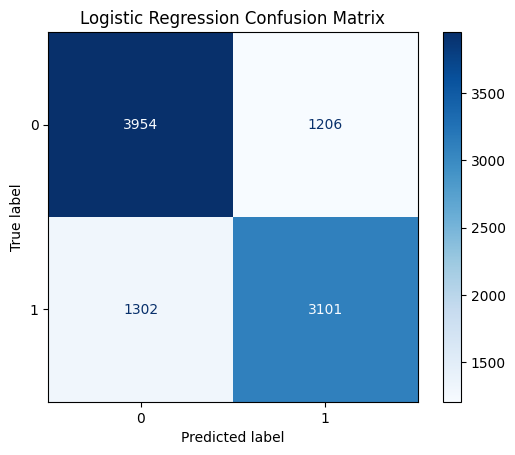

Cross-Validated ROC-AUC Scores: [0.82539662 0.79791617 0.80591668 0.80923736 0.81632972]
Mean CV ROC-AUC: 0.8110
Std CV ROC-AUC: 0.0093

--- Random Forest Evaluation ---
ROC-AUC Score: 0.8054
Accuracy: 0.7253
Precision: 0.6946
Recall: 0.7200
F1-Score: 0.7070
Confusion Matrix:
[[3766 1394]
 [1233 3170]]


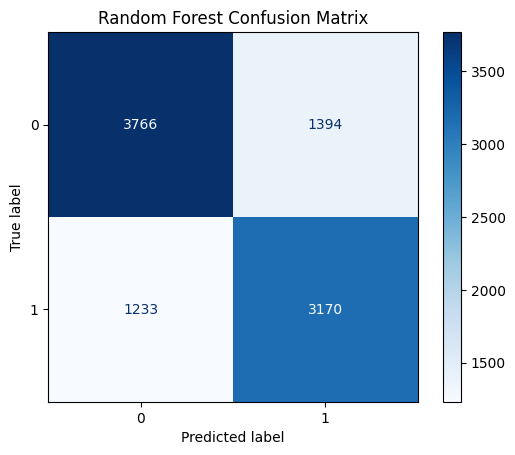

Cross-Validated ROC-AUC Scores: [0.81135393 0.78246949 0.79307506 0.78341151 0.80491323]
Mean CV ROC-AUC: 0.7950
Std CV ROC-AUC: 0.0115

--- XGBoost Evaluation ---
ROC-AUC Score: 0.7872
Accuracy: 0.6998
Precision: 0.7268
Recall: 0.5576
F1-Score: 0.6310
Confusion Matrix:
[[4237  923]
 [1948 2455]]


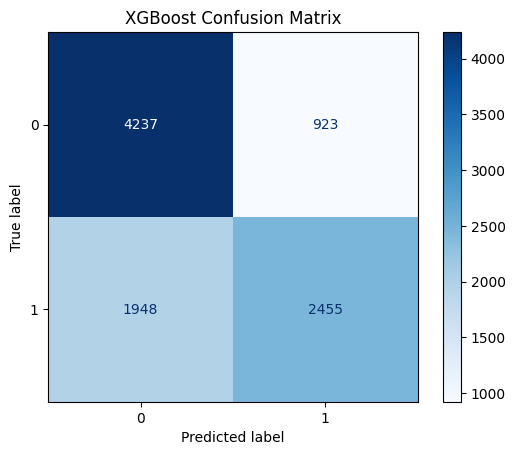

Cross-Validated ROC-AUC Scores: [0.78810471 0.76254301 0.75919553 0.76449359 0.77705085]
Mean CV ROC-AUC: 0.7703
Std CV ROC-AUC: 0.0108



In [50]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def evaluate_model(model, X_val, y_val, model_name="Model"):
    # Predict probabilities and classes
    y_probs = model.predict_proba(X_val)[:,1]  # Probabilities for class 1 (fake)
    y_preds = model.predict(X_val)

    # Calculate metrics
    roc_auc = roc_auc_score(y_val, y_probs)
    accuracy = accuracy_score(y_val, y_preds)
    precision = precision_score(y_val, y_preds)
    recall = recall_score(y_val, y_preds)
    f1 = f1_score(y_val, y_preds)
    cm = confusion_matrix(y_val, y_preds)

    print(f"--- {model_name} Evaluation ---")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # Cross-validation for ROC-AUC
    cv_scores = cross_val_score(model, X_val, y_val, cv=5, scoring='roc_auc', n_jobs=-1)
    print(f"Cross-Validated ROC-AUC Scores: {cv_scores}")
    print(f"Mean CV ROC-AUC: {np.mean(cv_scores):.4f}")
    print(f"Std CV ROC-AUC: {np.std(cv_scores):.4f}\n")


# Example usage: evaluate on your validation set (X_val, y_val)
evaluate_model(best_lr_model, X_val, y_val, model_name="Logistic Regression")
evaluate_model(best_rf_model, X_val, y_val, model_name="Random Forest")
evaluate_model(best_xgb_model, X_val, y_val, model_name="XGBoost")


# **Experiment Tracking**

In [53]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Ensure X_train and y_train are defined, and contain your text and labels
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Initialize experiment tracking DataFrame
experiment_log = pd.DataFrame(columns=[
    'Model', 'Params', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Comments'
])

# Define 5 pipeline-based experiments
experiments = [
    ('Logistic Regression (C=1)', Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
        ('clf', LogisticRegression(C=1, max_iter=200, random_state=42))
    ]), 'Baseline tuned LR'),

    ('Random Forest (100 trees)', Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]), 'Baseline tuned RF'),

    ('XGBoost (depth=6)', Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
        ('clf', XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                              eval_metric='logloss', random_state=42))
    ]), 'Baseline tuned XGB'),

    ('Logistic Regression (C=0.1)', Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
        ('clf', LogisticRegression(C=0.1, max_iter=200, random_state=42))
    ]), 'LR with stronger regularization'),

    ('Random Forest (depth=10)', Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
        ('clf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
    ]), 'Shallow RF')
]

# Run experiments
for name, model, comment in experiments:
    model.fit(X_subtrain, y_subtrain)
    preds = model.predict(X_val)
    probs = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else preds

    result = pd.DataFrame([{
        'Model': name,
        'Params': str(model.get_params()),
        'Accuracy': accuracy_score(y_val, preds),
        'Precision': precision_score(y_val, preds),
        'Recall': recall_score(y_val, preds),
        'F1': f1_score(y_val, preds),
        'ROC-AUC': roc_auc_score(y_val, probs),
        'Comments': comment
    }])

    experiment_log = pd.concat([experiment_log, result], ignore_index=True)

# Sort and display results
experiment_log = experiment_log.sort_values(by='ROC-AUC', ascending=False)

print("\n📊 Experiment Results:\n")
print(experiment_log[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'Comments']].round(3))

# Optional: Save to CSV
experiment_log.to_csv("experiment_tracking_results.csv", index=False)


<ipython-input-53-0c3bea7a1a7f>:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  experiment_log = pd.concat([experiment_log, result], ignore_index=True)



📊 Experiment Results:

                         Model  Accuracy  Precision  Recall     F1  ROC-AUC  \
0    Logistic Regression (C=1)     0.781      0.762   0.763  0.762    0.865   
3  Logistic Regression (C=0.1)     0.769      0.776   0.702  0.737    0.852   
1    Random Forest (100 trees)     0.760      0.735   0.749  0.742    0.843   
2            XGBoost (depth=6)     0.701      0.734   0.551  0.630    0.795   
4     Random Forest (depth=10)     0.611      0.842   0.191  0.312    0.789   

                          Comments  
0                Baseline tuned LR  
3  LR with stronger regularization  
1                Baseline tuned RF  
2               Baseline tuned XGB  
4                       Shallow RF  


# **Final Prediction & Submission**

In [57]:
import pandas as pd

# 1. Load test data
test_df = pd.read_csv("x_test.csv")
X_test_texts = test_df['text']
ids = test_df['ID']

# 2. Predict probabilities using the best model (example: best_lr_model)
# Ensure best_lr_model is already trained
probabilities = best_lr_model.predict_proba(X_test_texts)[:, 1]

# 3. Apply threshold: if prob > 0.5 -> 1 else 0
predicted_labels = (probabilities > 0.5).astype(int)

# 4. Create submission DataFrame
submission_df = pd.DataFrame({
    'ID': ids,
    'prediction': predicted_labels
})

# 5. Save to CSV
submission_df.to_csv("final_submission.csv", index=False)

print("✅ Final prediction file 'final_submission.csv' created with labels 0 or 1.")


✅ Final prediction file 'final_submission.csv' created with labels 0 or 1.


In [62]:
res=pd.read_csv("final_submission.csv")
print("First 5 predictions:")
print(res.head())
print("\n")
print("Last 5 predictions:")
print(res.tail())

First 5 predictions:
   ID  prediction
0   0           1
1   1           0
2   2           0
3   3           0
4   4           0


Last 5 predictions:
          ID  prediction
11950  11995           0
11951  11996           0
11952  11997           0
11953  11998           0
11954  11999           0
